In [2]:
import os
import csv
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

from transformers import pipeline

In [3]:
languages = ['arabic','bulgarian','english','german','italian']

In [3]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


In [4]:
def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

In [6]:
all_data = []

for language in languages:
    print('Processing', language)
    folder = f'/kaggle/input/clef2025-checkthat/data{os.sep}{language}'
    files = os.listdir(folder)
    
    language_test = None
    language_dev = None
    
    for file in files:
        if file.endswith('.tsv'):
            if 'test' in file:
                test = pd.read_csv(f'{folder}{os.sep}{file}', sep='\t', quoting=csv.QUOTE_NONE)
                test[['positive', 'neutral', 'negative']] = test.apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
                test['language'] = language
                test['set_type'] = 'test'
                language_test = test
            elif 'dev' in file and 'test' not in file:
                dev = pd.read_csv(f'{folder}{os.sep}{file}', sep='\t', quoting=csv.QUOTE_NONE)
                dev[['positive', 'neutral', 'negative']] = dev.apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
                dev['language'] = language
                dev['set_type'] = 'dev'
                language_dev = dev
    
    if language_test is not None:
        all_data.append(language_test)
    if language_dev is not None:
        all_data.append(language_dev)

# Combine all data into a single dataframe
combined_df = pd.concat(all_data, ignore_index=True)
print(f"Combined dataset has {len(combined_df)} rows and includes data from {combined_df['language'].nunique()} languages")

Processing arabic


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processing bulgarian
Processing english
Processing german
Processing italian
Combined dataset has 4733 rows and includes data from 5 languages


<Axes: xlabel='sentiment', ylabel='score'>

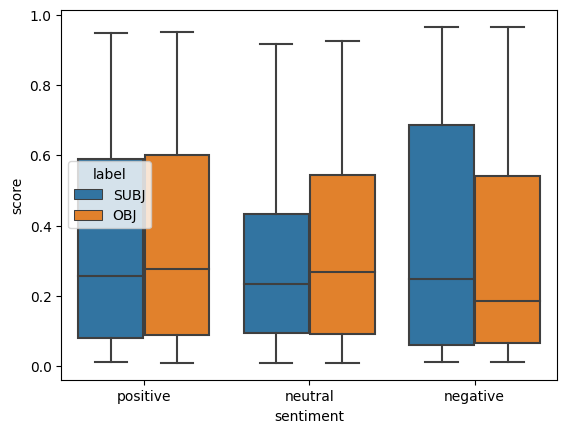

In [32]:
melted_df = combined_df.melt(id_vars=["label"], 
                             value_vars=["positive", "neutral", "negative"],
                             var_name="sentiment",
                             value_name="score")

# Plotting
sns.boxplot(x="sentiment", y="score", hue="label", data=melted_df)

In [34]:
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)
filepath = os.path.join(save_dir, "global_sentiment.tsv")
combined_df.to_csv(filepath, index=False, sep='\t')

# wrong prediction per model

In [5]:
global_sentiment = pd.read_csv(f"results{os.sep}global_sentiment.tsv", sep='\t', quoting=csv.QUOTE_NONE)
global_sentiment.head()

,sentence_id,sentence,label,positive,neutral,negative,language,set_type,solved_conflict
0,Almayadeen_15_3,في ربع القرن الأخير، شنّت الدوائر الغربية والإ...,SUBJ,0.888509,0.085842,0.025650,arabic,test,NaN
1,MIS_2615-eurl_03_023,- موقع ذا هيل: مناقشات مسؤولي الإدارة بشأن تفع...,SUBJ,0.125638,0.411801,0.462561,arabic,test,NaN
2,Almayadeen_43_1,مع كلّ عزيمة وعنفوان أبطال مخيم جنين وأهل جنين...,OBJ,0.192436,0.314860,0.492704,arabic,test,NaN
3,AJ_24_8,فصائل المقاومة في غزة، ضمن خطتها الإعلامية، وح...,SUBJ,0.878047,0.099509,0.022445,arabic,test,NaN
4,MIS_1086-curl_06_008,ونوه تشومسكي إلى أنّ السلطة الفلسطينيّة تضخ مح...,OBJ,0.877828,0.099702,0.022470,arabic,test,NaN


In [6]:
english_df_deberta = pd.read_csv(f"results{os.sep}test_english_predicted.tsv", sep='\t', quoting=csv.QUOTE_NONE)
english_df_modernbert = pd.read_csv(f"results{os.sep}test_english_modern_predicted.tsv", sep='\t', quoting=csv.QUOTE_NONE)
english_df_sentiment = pd.read_csv(f"results{os.sep}test_english_sentiment_predicted.tsv", sep='\t', quoting=csv.QUOTE_NONE)

In [15]:
# Create a dataframe that combines the true labels and predictions
df = global_sentiment[global_sentiment['language'] == 'english']
df = df.rename(columns={'label': 'true_labels'})

# Merge predictions from each model
df = df.merge(english_df_deberta, on='sentence_id', how='left')
df = df.rename(columns={'label': 'english'})

df = df.merge(english_df_modernbert, on='sentence_id', how='left')
df = df.rename(columns={'label': 'english-modern-bert'})

df = df.merge(english_df_sentiment, on='sentence_id', how='left')
df = df.rename(columns={'label': 'english-sentiment'})

# Find incorrect predictions for each model
wrong = df[df["true_labels"] != df["english"]]
wrong_bert = df[df["true_labels"] != df["english-modern-bert"]]
wrong_sentiment = df[df["true_labels"] != df["english-sentiment"]]

In [22]:
print(f"english model got {len(wrong)} wrong predictions")
print(f"english-modern-bert model got {len(wrong_bert)} wrong predictions")
print(f"english-sentiment model got {len(wrong_sentiment)} wrong predictions")


english model got 577 wrong predictions
english-modern-bert model got 584 wrong predictions
english-sentiment model got 555 wrong predictions


# What the sentiment model got right

In [26]:
new_pd = df[(df["true_labels"] == df["english-sentiment"]) & (df["english-sentiment"] != df["english"])]
new_pd = new_pd.drop(columns=["english-sentiment", "english", "english-modern-bert", "sentence_id"])

print("For correctly identified by sentiment but wrongly identified by english")
print("len: ",len(new_pd))
print()
print("Mean and std of positive sentiment for objective: ",new_pd[new_pd["true_labels"] == "OBJ"]["positive"].mean(),"-",new_pd[new_pd["true_labels"] == "OBJ"]["positive"].std())
print("Mean and std of neutral sentiment for objective: ",new_pd[new_pd["true_labels"] == "OBJ"]["neutral"].mean(),"-",new_pd[new_pd["true_labels"] == "OBJ"]["neutral"].std())
print("Mean and std of negative sentiment for objective: ",new_pd[new_pd["true_labels"] == "OBJ"]["negative"].mean(),"-",new_pd[new_pd["true_labels"] == "OBJ"]["negative"].std())
print("-"*80)
print("Mean and std of positive sentiment for subjective: ",new_pd[new_pd["true_labels"] == "SUBJ"]["positive"].mean(),"-",new_pd[new_pd["true_labels"] == "SUBJ"]["positive"].std())
print("Mean and std of neutral sentiment for subjective: ",new_pd[new_pd["true_labels"] == "SUBJ"]["neutral"].mean(),"-",new_pd[new_pd["true_labels"] == "SUBJ"]["neutral"].std())
print("Mean and std of negative sentiment for subjective: ",new_pd[new_pd["true_labels"] == "SUBJ"]["negative"].mean(),"-",new_pd[new_pd["true_labels"] == "SUBJ"]["negative"].std())

For correctly identified by sentiment but wrongly identified by english
len:  33

Mean and std of positive sentiment for objective:  0.3248155744815314 - 0.20417269853457148
Mean and std of neutral sentiment for objective:  0.31054739098719975 - 0.31057937874864866
Mean and std of negative sentiment for objective:  0.36463704022268456 - 0.3243767705151058
--------------------------------------------------------------------------------
Mean and std of positive sentiment for subjective:  0.2378415366013845 - 0.19106010062039944
Mean and std of neutral sentiment for subjective:  0.24626997951418161 - 0.35379360038547253
Mean and std of negative sentiment for subjective:  0.5158884841948748 - 0.3560474683976414


In [27]:
new_pd = df[(df["true_labels"] != df["english-sentiment"]) & (df["true_labels"] == df["english"])]
new_pd = new_pd.drop(columns=["english-sentiment", "english", "english-modern-bert", "sentence_id"])

print("For correctly identified by english but wrongly identified by sentiment")
print("len: ",len(new_pd))
print()
print("Mean and std of positive sentiment for objective: ",new_pd[new_pd["true_labels"] == "OBJ"]["positive"].mean(),"-",new_pd[new_pd["true_labels"] == "OBJ"]["positive"].std())
print("Mean and std of neutral sentiment for objective: ",new_pd[new_pd["true_labels"] == "OBJ"]["neutral"].mean(),"-",new_pd[new_pd["true_labels"] == "OBJ"]["neutral"].std())
print("Mean and std of negative sentiment for objective: ",new_pd[new_pd["true_labels"] == "OBJ"]["negative"].mean(),"-",new_pd[new_pd["true_labels"] == "OBJ"]["negative"].std())
print("-"*80)
print("Mean and std of positive sentiment for subjective: ",new_pd[new_pd["true_labels"] == "SUBJ"]["positive"].mean(),"-",new_pd[new_pd["true_labels"] == "SUBJ"]["positive"].std())
print("Mean and std of neutral sentiment for subjective: ",new_pd[new_pd["true_labels"] == "SUBJ"]["neutral"].mean(),"-",new_pd[new_pd["true_labels"] == "SUBJ"]["neutral"].std())
print("Mean and std of negative sentiment for subjective: ",new_pd[new_pd["true_labels"] == "SUBJ"]["negative"].mean(),"-",new_pd[new_pd["true_labels"] == "SUBJ"]["negative"].std())

For correctly identified by english but wrongly identified by sentiment
len:  11

Mean and std of positive sentiment for objective:  0.23662361254294714 - 0.14646874923029649
Mean and std of neutral sentiment for objective:  0.36990565868715447 - 0.3239833152264322
Mean and std of negative sentiment for objective:  0.3934707045555115 - 0.40861249938845656
--------------------------------------------------------------------------------
Mean and std of positive sentiment for subjective:  0.2941310741007328 - 0.2388239411881043
Mean and std of neutral sentiment for subjective:  0.3768701311200857 - 0.36035385933070224
Mean and std of negative sentiment for subjective:  0.32899880735203624 - 0.34206677957254844


From the results above, you can see that the sentiment model is able to recognize subjectivity better in the context of high negativity sentiment, while for all the other cases the sentiment is almost perfectly balanced (~ 1/3)

In [28]:
# 3 examples for sentences that are correctly identified by sentiment but wrongly identified by english

# Find examples where sentiment model is correct but english model is wrong
examples = df[(df["true_labels"] == df["english-sentiment"]) & (df["true_labels"] != df["english"])].copy()

# Display 3 examples with their sentences and sentiment scores
for i, (idx, row) in enumerate(examples.iloc[:3].iterrows()):
    print(f"Example {i+1}:")
    print(f"Sentence: {row['sentence']}")
    print(f"True label: {row['true_labels']}")
    print(f"English model prediction: {row['english']}")
    print(f"Sentiment model prediction: {row['english-sentiment']}")
    print(f"Sentiment scores: positive={row['positive']:.3f}, neutral={row['neutral']:.3f}, negative={row['negative']:.3f}")
    print("-" * 80)

Example 1:
Sentence: Googled how to cook a good lobster and I read how hard it is to get it good because it can turn very tough, rubbery.
True label: OBJ
English model prediction: SUBJ
Sentiment model prediction: OBJ
Sentiment scores: positive=0.129, neutral=0.025, negative=0.847
--------------------------------------------------------------------------------
Example 2:
Sentence: This is why the more Osborne slashed public spending in the 2010s, the more money he needed to borrow.
True label: OBJ
English model prediction: SUBJ
Sentiment model prediction: OBJ
Sentiment scores: positive=0.411, neutral=0.117, negative=0.473
--------------------------------------------------------------------------------
Example 3:
Sentence: This was inaccurate.
True label: OBJ
English model prediction: SUBJ
Sentiment model prediction: OBJ
Sentiment scores: positive=0.079, neutral=0.021, negative=0.901
--------------------------------------------------------------------------------
